In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randint, rand
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
                                                                ##### Plot #####
def plot_image(y,n):
  plt.figure(figsize=(20,1))
  plt.scatter(hnum[0],y)
  plt.plot(hnum[0],y)     
  plt.axis('off')
  plt.title(f"{n}")
  plt.show()

In [ ]:
# Upload dataset
files.upload()

In [ ]:
                           ##### dataset_full including inputs and outputs #####
xy=pd.read_csv("dataset_full60.csv")
## Split into x,y ##
y=np.array([xy["efficiency"],xy["stress"],xy["deformation"]]).T
X=xy.drop(columns=["efficiency","stress","deformation"])
## float64 --> 32 ##
X=np.array(X,dtype="float32")
y=y.astype(np.float32)
## Scale the y ##
scaler= MinMaxScaler()
scaled_y= scaler.fit_transform(y)
Y=np.array(scaled_y)

In [ ]:
                                                   ### RandomForestRegressor ###
cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=2)
forest=RandomForestRegressor()
forest_cross=cross_val_score(forest,X,Y,scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
final_forest=forest.fit(X,Y)

In [ ]:
# Upload x_dataset, y_dataset
files.upload()

In [ ]:
                            ##### dataset including only inputs (features) #####
v= pd.read_csv("y_dataset.csv")
h= pd.read_csv("x_dataset.csv")
vnum=v.to_numpy(dtype="float32")
hnum=h.to_numpy(dtype="float32")
## Split into train and test ##
train,test = train_test_split(vnum,test_size=0.2,random_state=42)

In [ ]:
                                                            ##### Sampling #####
class Sampling(keras.layers.Layer):
  def call(self,inputs):
      mean,log_var=inputs
      return keras.backend.random_normal(shape= tf.shape(log_var)) * keras.backend.exp(log_var/2) + mean

In [ ]:
class layer(keras.layers.Layer):
  def call(self,input):
    list1=[]
    list2=[]
    if input.shape[0]:
      for n in range (input.shape[0]):
        x=input[n]
        for i,lay in enumerate(discriminator.layers):
          x=tf.reshape(x,[1,-1])
          if i==0:
            x=lay(x)
            mean1=keras.backend.mean(x)
            list1.append(mean1)
          elif i==1:
            x=lay(x)
            mean2=keras.backend.mean(x)
            list2.append(mean2)
          else:
            break
            
      out1=tf.stack(list1)
      out2=tf.stack(list2)
      return out1, out2

In [ ]:
# Upload saved weights
files.upload()

In [ ]:
codings_size=10
### Encoder
inputs=keras.layers.Input(shape=(200,))
z=keras.layers.Dense(150, activation=keras.layers.LeakyReLU(alpha=0.1))(inputs)
z=keras.layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.1))(z)
codings_mean=keras.layers.Dense(codings_size)(z)
codings_log_var=keras.layers.Dense(codings_size)(z)
codings=Sampling()([codings_mean,codings_log_var])
encoder=keras.models.Model(inputs=[inputs],outputs=[codings])
### Decoder
decoder_inputs=keras.layers.Input(shape=[codings_size])
x=keras.layers.Dense(100,activation=keras.layers.LeakyReLU(alpha=0.1))(decoder_inputs)
x=keras.layers.Dense(150,activation=keras.layers.LeakyReLU(alpha=0.1))(x)
outputs=keras.layers.Dense(200,activation="tanh")(x)
decoder=keras.models.Model(inputs=[decoder_inputs],outputs=[outputs])

### Discriminator
discriminator=keras.models.Sequential([
    keras.layers.Dense(150, activation=keras.layers.LeakyReLU(alpha=0.1), input_shape=(200,)),
    keras.layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.1)),
    keras.layers.Dense(1, activation="sigmoid")
])
                ### loss and compile ###     
optimizer=keras.optimizers.Adam(learning_rate=0.0005)
### 0. Discriminator ###
discriminator.load_weights("weights_dis_5_70.h5")
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
discriminator.trainable=False
### 1. VAE ###
decoder.load_weights("weights_dec_5_70.h5")
encoder.load_weights("weights_enc_5_70.h5")
codings=encoder(inputs)
reconstructions=decoder(codings)
vae=keras.models.Model(inputs=[inputs], outputs=[reconstructions])
## prior_loss
prior_loss= -0.5* keras.backend.sum(1 + codings_log_var - keras.backend.exp(codings_log_var) - keras.backend.square(codings_mean), axis=-1)
prior_loss=keras.backend.mean(prior_loss)/200.
vae.add_loss(prior_loss)
vae.compile(loss="mean_squared_error", optimizer=optimizer)
### 2. GAN ###
gan=keras.models.Sequential([decoder,discriminator])
### 3. vaeGan ###
## layer loss
output=layer()(vae(inputs))
vaeGan=keras.models.Model(inputs=[inputs],outputs=[output])
vaeGan.compile(loss= "mean_squared_error", optimizer=optimizer)

In [ ]:
                                                  ##### Objective function #####
def predictions(decoded):
    pre=final_forest.predict(decoded)            
    ## Invert scaled to real data ##
    prediction=scaler.inverse_transform(pre) 
    return prediction

In [ ]:
                                                     ##### Decode function #####
def decode(individual):
    return decoder(individual)

In [ ]:
                                                    ##### Fitness function #####
def fitness(p, efficiency_t):
  efficiency= predictions(decode(p))[0,0]
  fitness_score= (efficiency_t - efficiency) / efficiency_t
  return fitness_score

In [ ]:
																							##### tournament (Selection) #####
def selection(pop,efficiency_t,k=5):
		# first random selection
		selection_ix = randint(len(pop))
		for ix in randint(0, len(pop), k-1):
				p1=np.array(pop[selection_ix]).reshape(1,-1)
				fitnessscore1=fitness(p1, efficiency_t)
				p2=np.array(pop[ix]).reshape(1,-1)
				fitnessscore2=fitness(p2, efficiency_t)
				# check if better (e.g. perform a tournament)
				if fitnessscore2 <= fitnessscore1:
						selection_ix = ix
		return pop[selection_ix]

In [ ]:
                                                          ##### Population function #####
## real dataset ##
def real(n_pop,feature_domain):
  pop=list()
  for n in randint(0,70,n_pop):
    p=feature_domain[n]
    pop.append(p)
  return pop

####################

## interpolated dataset ##
def interpolate(n_pop,feature_domain):
  pop=list()
  for n in randint(0,70,n_pop):
    z1=feature_domain[n]
    m= randint(0,70)
    if m==n:
      m+=1
    z2=feature_domain[m]
    neu=rand()
    z3=neu*z1+(1-neu)*z2
    pop.append(z3)
  return pop

####################

# extrapolated dataset ##
def extrapolate(n_pop,feature_domain):
  pop=list()
  for n in randint(0,70,n_pop):
    z1=feature_domain[n]
    m= randint(0,70)
    if m==n:
      m+=1
    z2=feature_domain[m]
    neu=-rand()
    z3=neu*z1+(1-neu)*z2
    pop.append(z3)
  return pop

####################

## random dataset ##
def random(n_pop,codings_size):
  pop=[]
  noise=tf.random.normal(shape=[n_pop,codings_size])
  pop=np.array(noise)
  pop=pop.tolist()
  return pop

####################

## combined dataset ##
def combination(n_pop,feature_domain,codings_size):
  poop= (interpolate(int(n_pop/3),feature_domain)+ extrapolate(int(n_pop/3),feature_domain)+ random(int(n_pop/3),codings_size))
  return poop

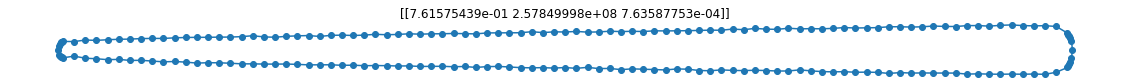

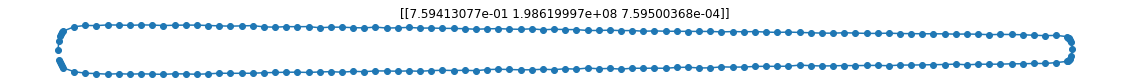

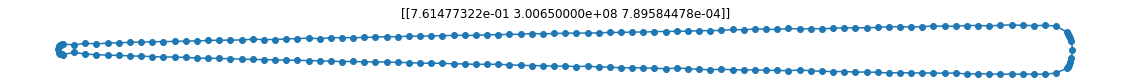

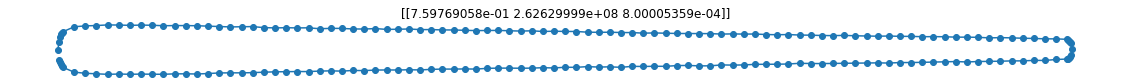

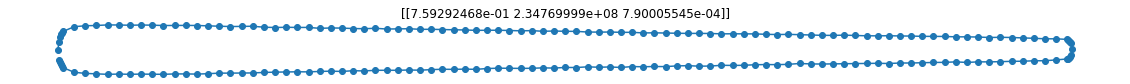

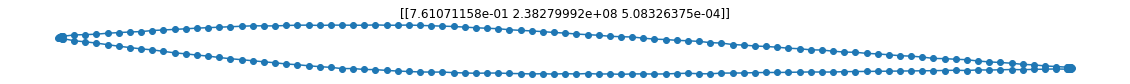

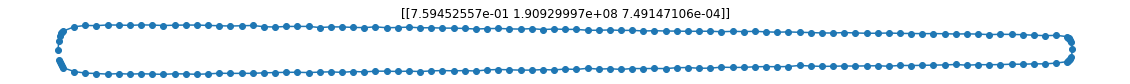

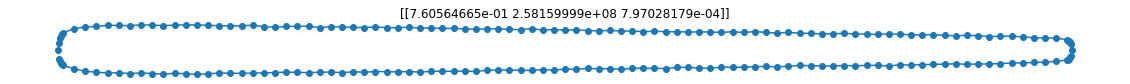

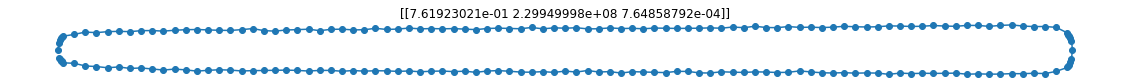

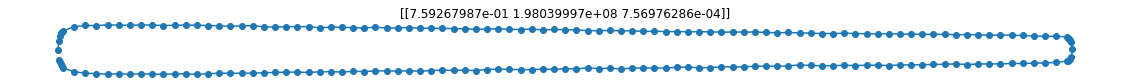

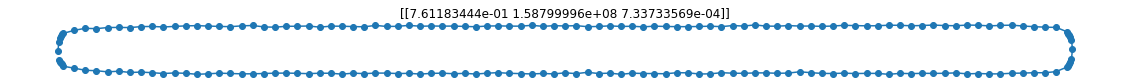

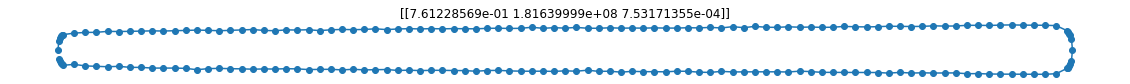

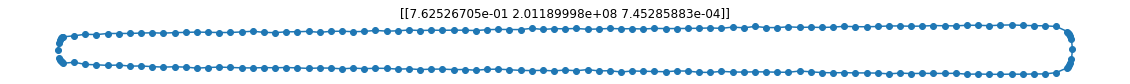

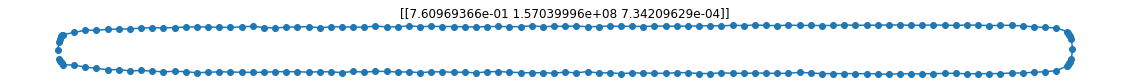

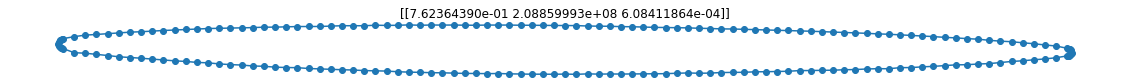

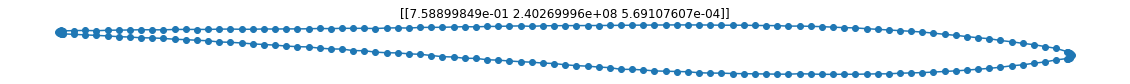

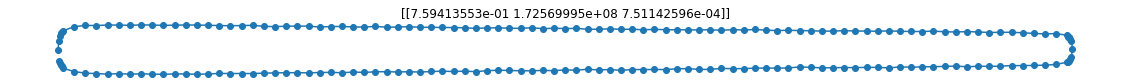

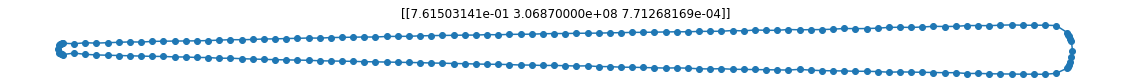

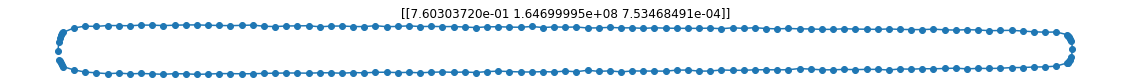

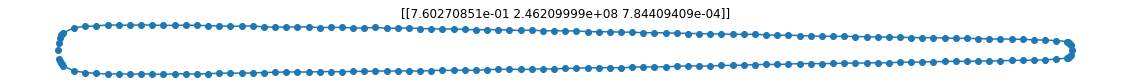

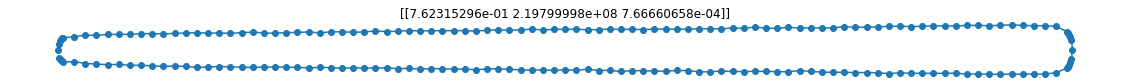

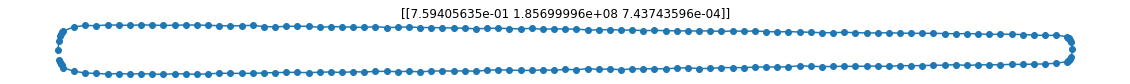

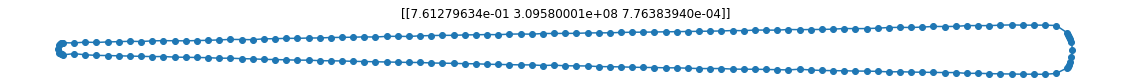

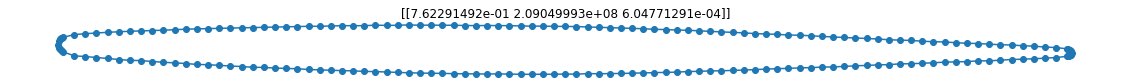

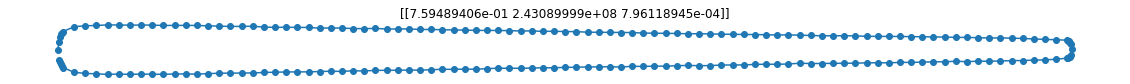

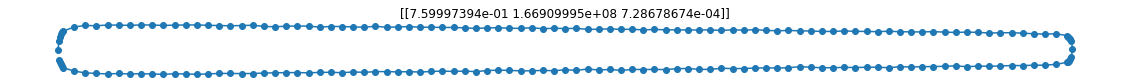

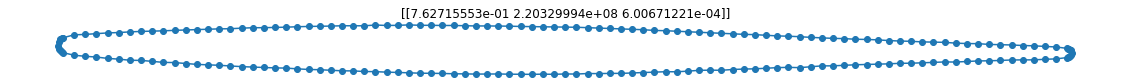

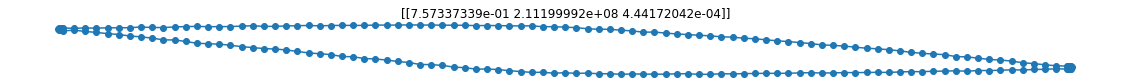

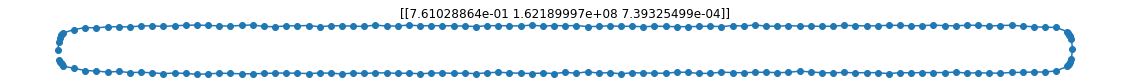

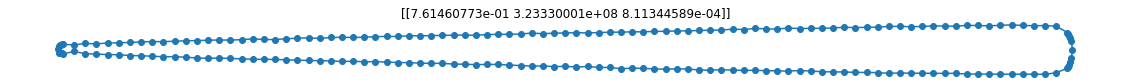

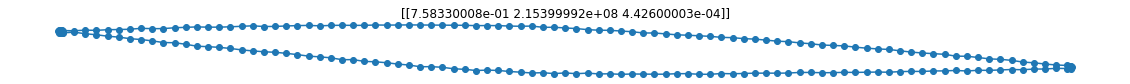

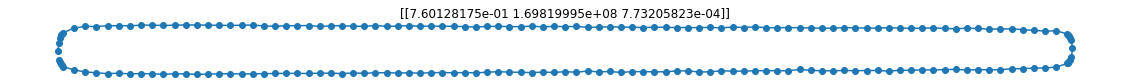

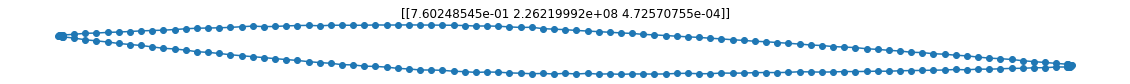

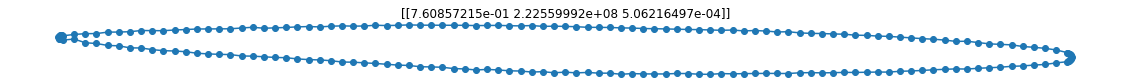

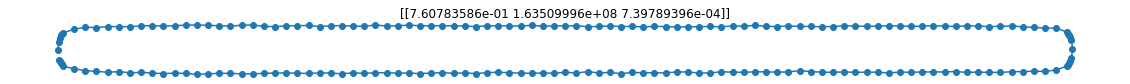

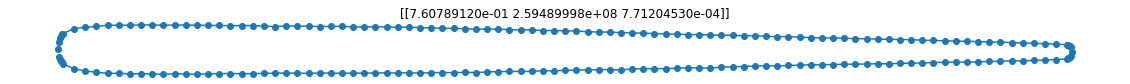

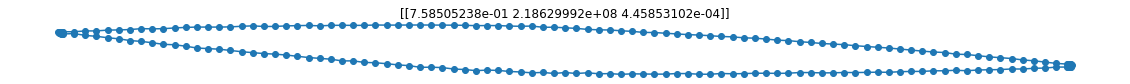

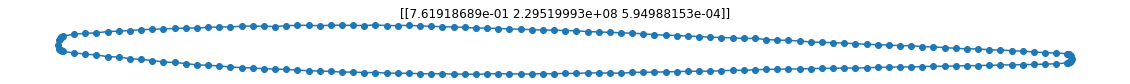

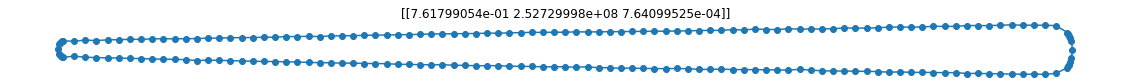

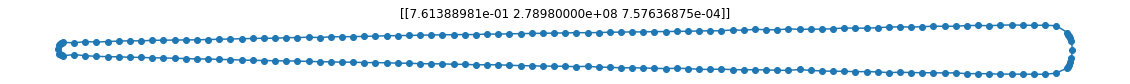

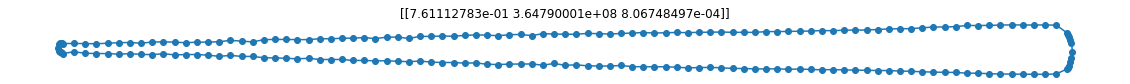

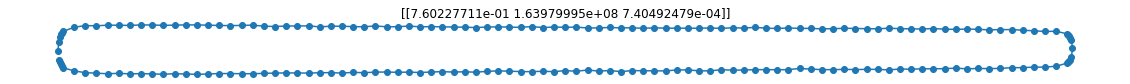

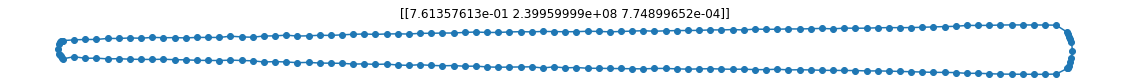

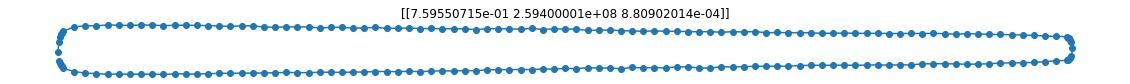

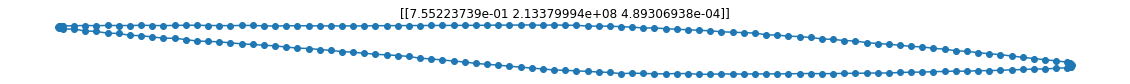

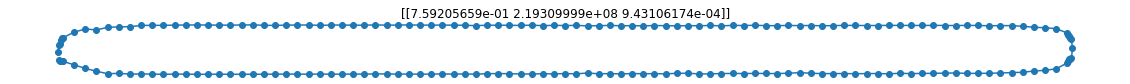

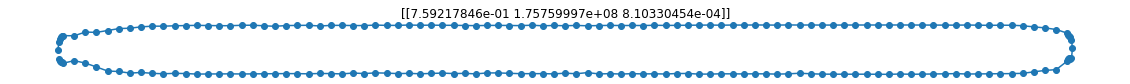

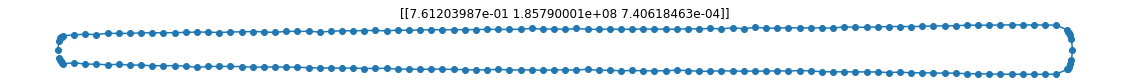

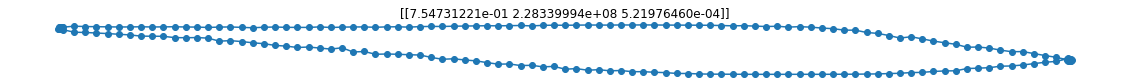

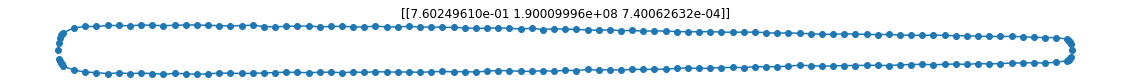

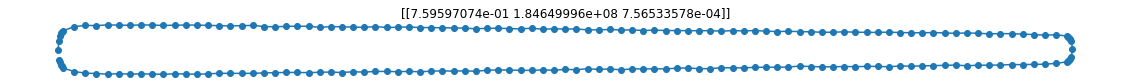

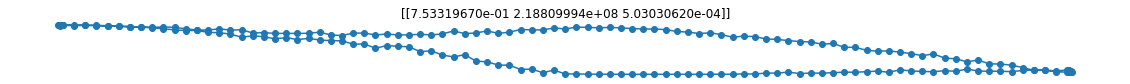

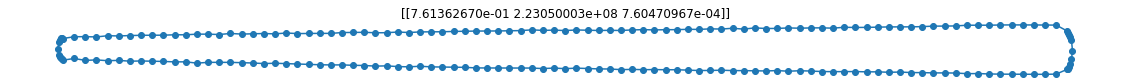

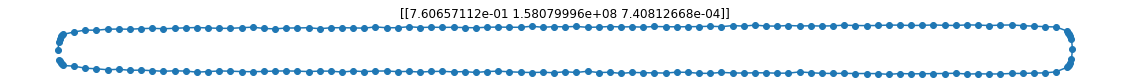

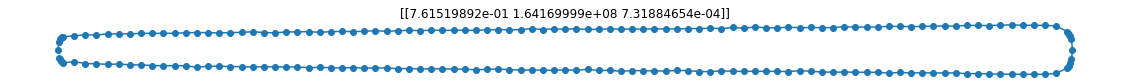

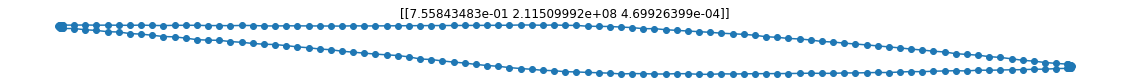

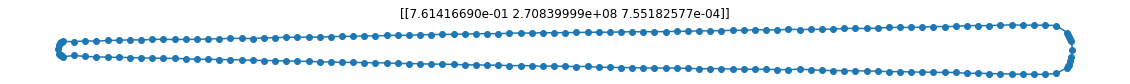

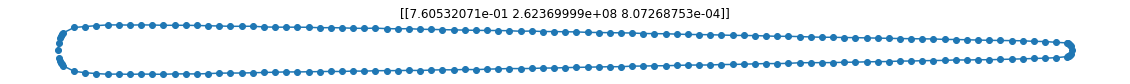

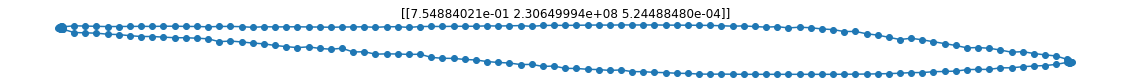

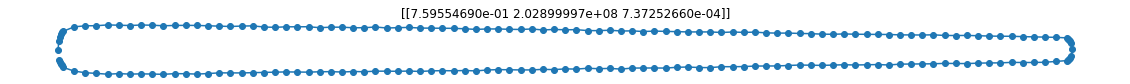

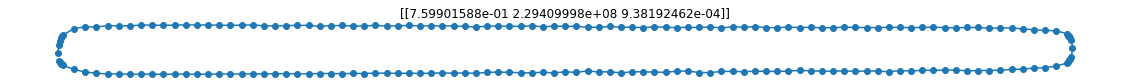

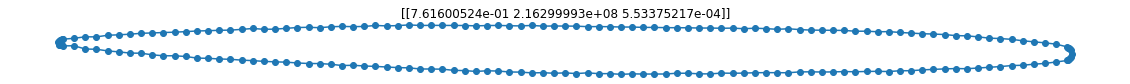

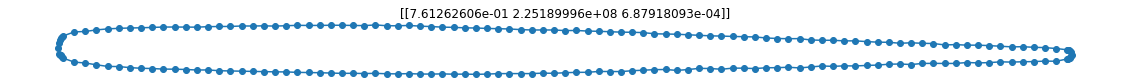

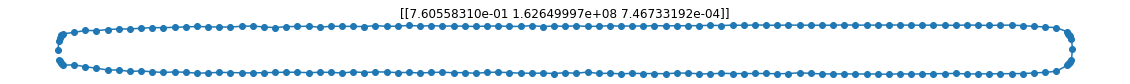

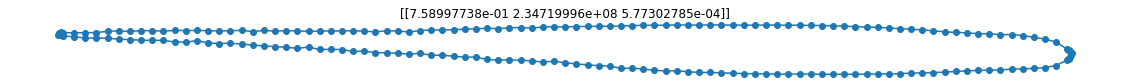

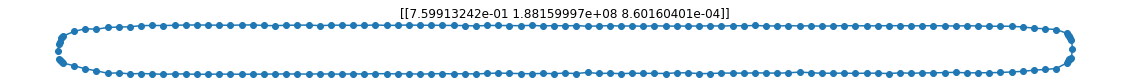

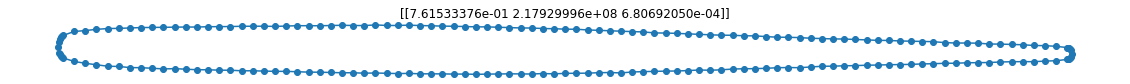

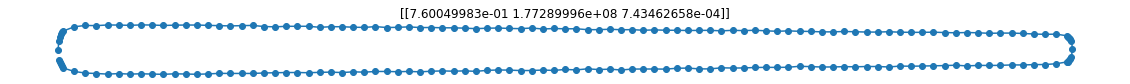

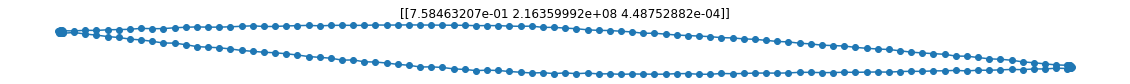

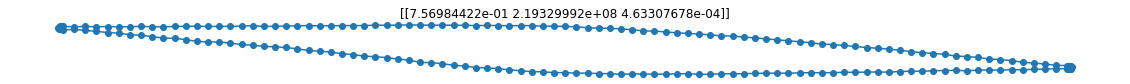

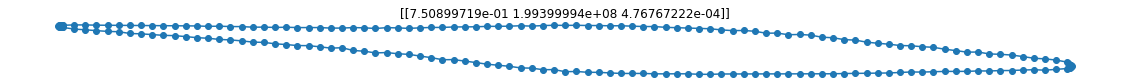

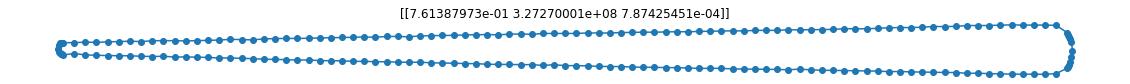

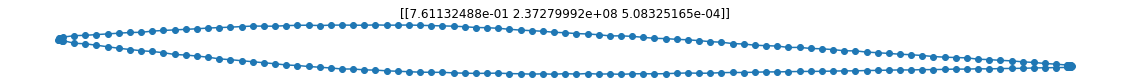

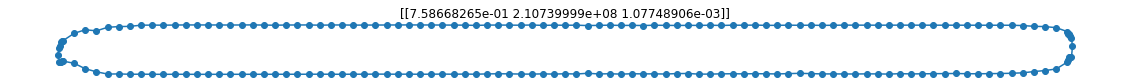

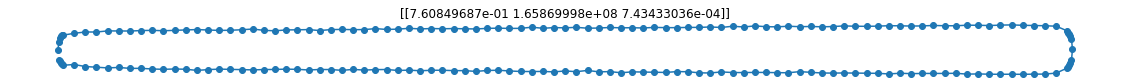

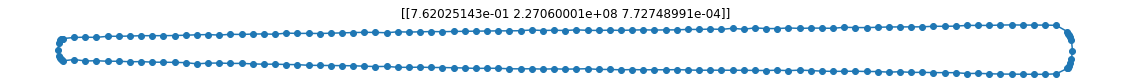

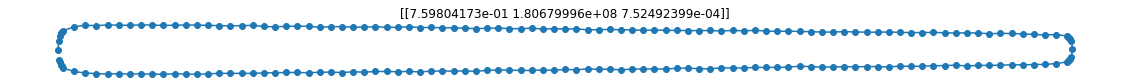

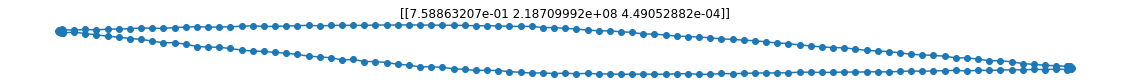

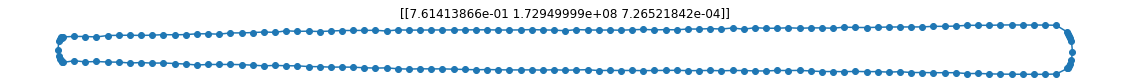

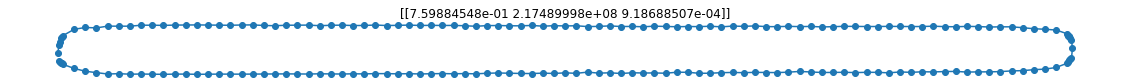

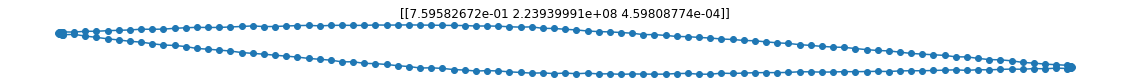

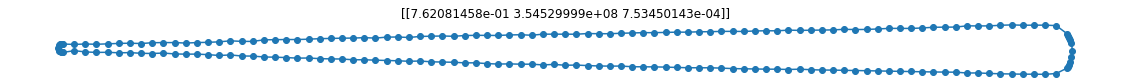

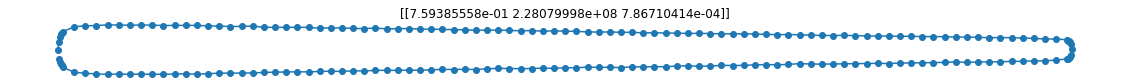

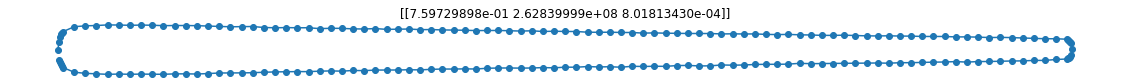

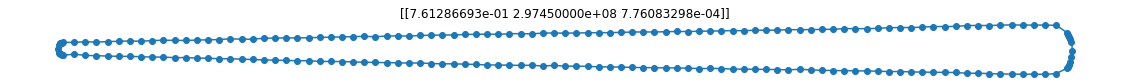

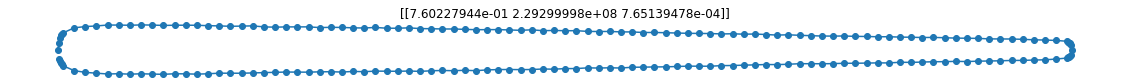

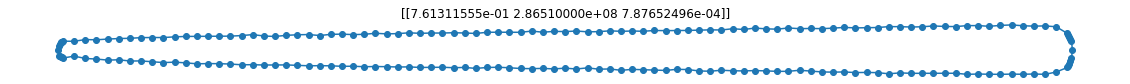

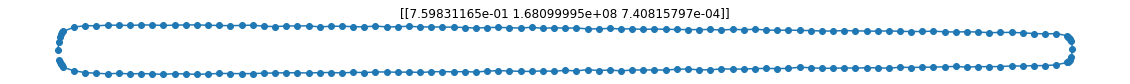

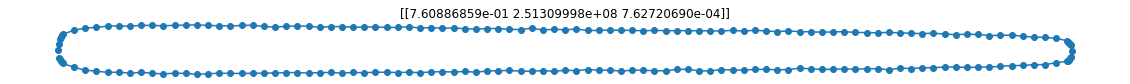

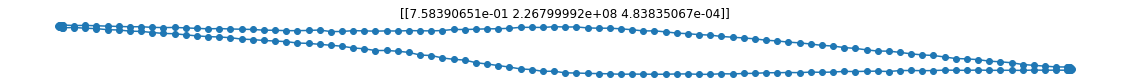

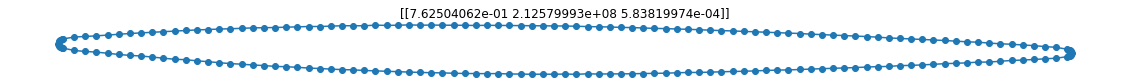

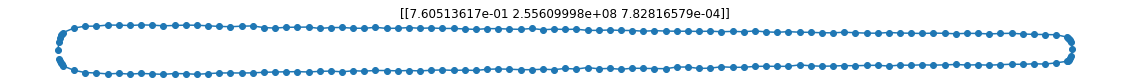

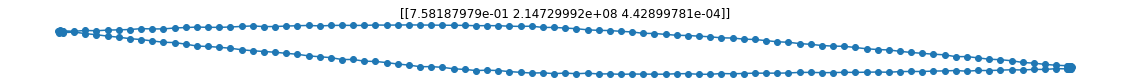

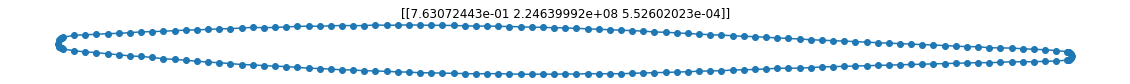

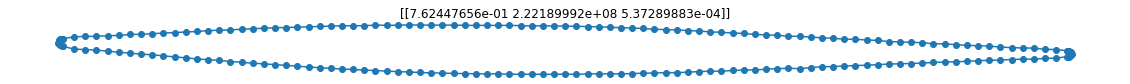

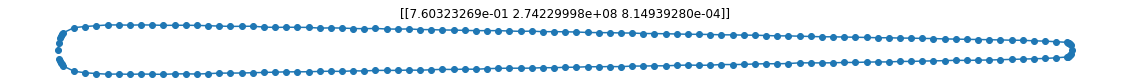

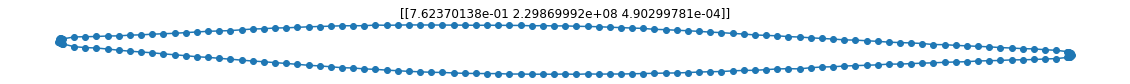

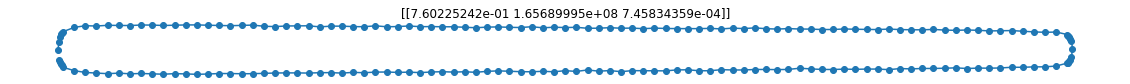

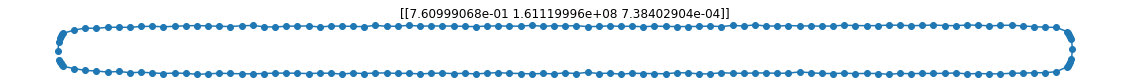

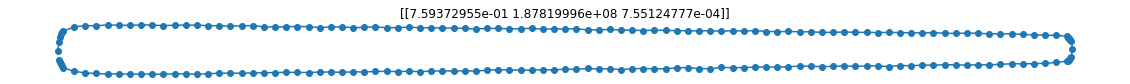

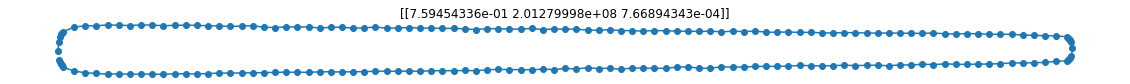

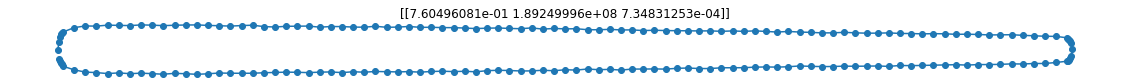

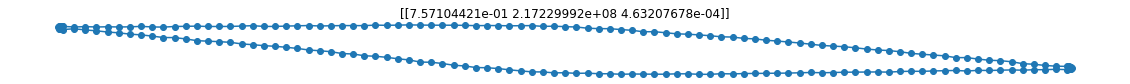

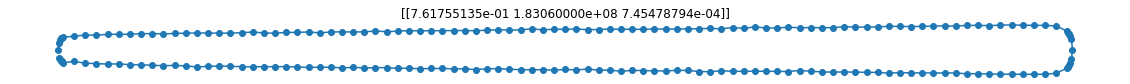

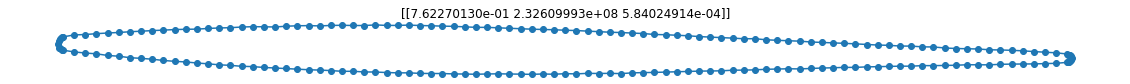

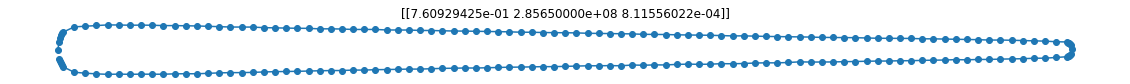

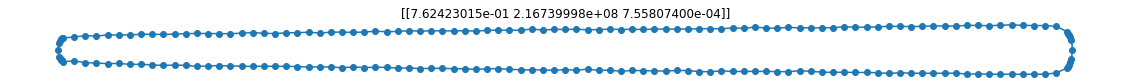

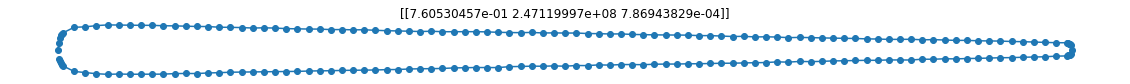

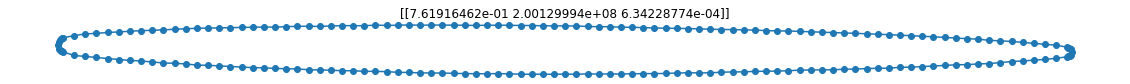

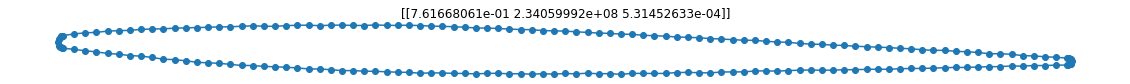

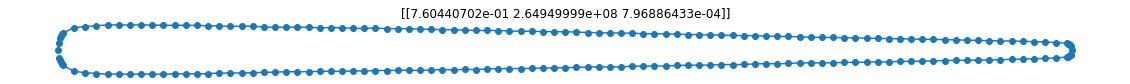

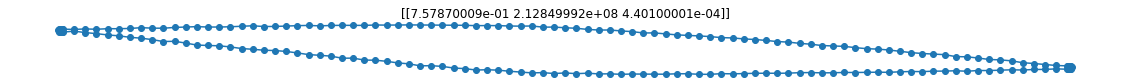

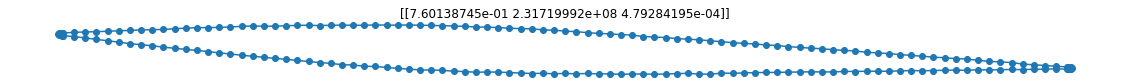

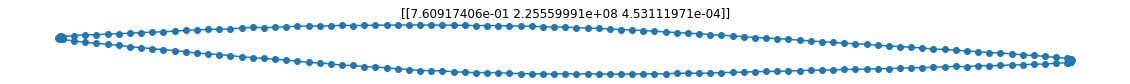

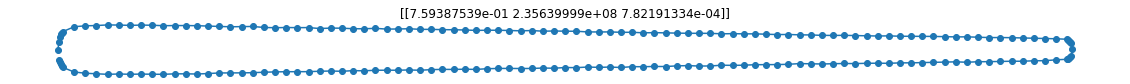

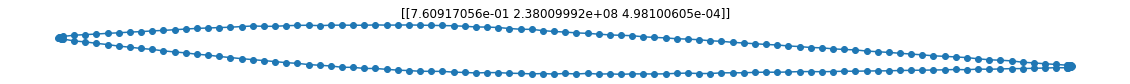

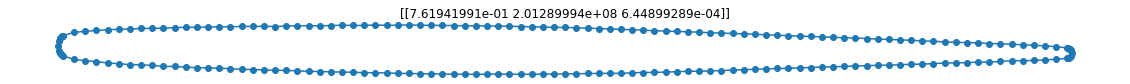

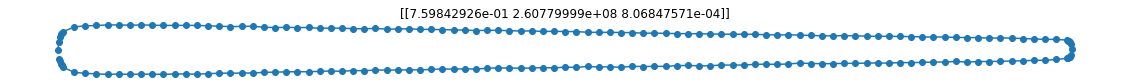

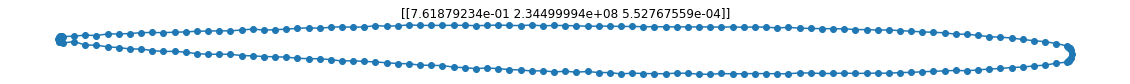

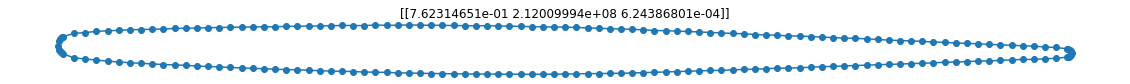

gen=  0
best0=  [[-1.12692404  0.11655457  0.09354269 -0.20180467 -0.29993713 -0.48231184
   1.04047596 -0.37009022 -0.67621309 -0.32494637]] 
 best_prediction0=  [0.7623146511495688, 212009993.90750113, 0.0006243868013214113]


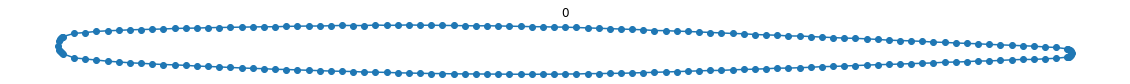

gen=  1
best1=  [[ 0.22113371 -0.05164466  0.61065561  2.65714288  2.25662756  2.55259037
   2.81697977 -0.55589342 -0.30686986 -1.09679008]] 
 best_prediction1=  [0.7597504188990383, 244639995.39242676, 0.0005795633164445718]


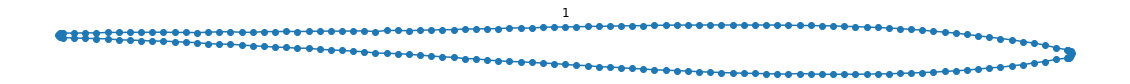

gen=  2
best2=  [[ 0.13784099 -1.7185297   1.05025697  0.20898327  0.71491307  0.00703691
   0.32629523 -0.71632606 -0.64827251  1.63212347]] 
 best_prediction2=  [0.7607136335586838, 224279991.31643555, 0.000467118512581958]


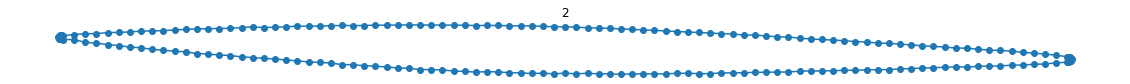

gen=  3
best3=  [[ 1.47232088  1.35902798 -0.05025697  0.20898327  0.71491307  0.04813631
   0.53215474 -0.48154113  1.89539063 -0.1599364 ]] 
 best_prediction3=  [0.7617408049824551, 222229992.50114796, 0.0005181390768116132]


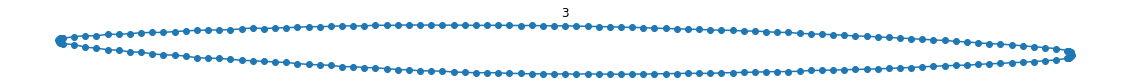

gen=  4
best4=  [[ 1.38882735 -1.92839241  1.09887451  0.79427218 -0.34834117  1.1942459
   2.172526   -0.4693417   0.11677874 -1.57186425]] 
 best_prediction4=  [0.763057622812638, 225249992.06129035, 0.0005494456031393758]


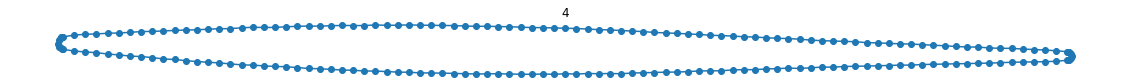

gen=  5
best5=  [[ 2.72363675  0.28990293 -0.23724151  0.36267257 -0.34834117 -0.1942459
  -1.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction5=  [0.7632199737385598, 220319992.621587, 0.0005675464217326881]


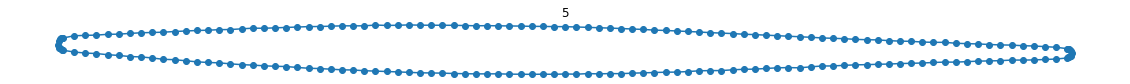

gen=  6
best6=  [[-1.72363675  0.28990293  1.09887451  0.79427218 -0.34834117 -0.10667043
   0.70875838 -0.4693417   0.11677874 -1.57186425]] 
 best_prediction6=  [0.7631327036379537, 224599991.71771362, 0.0005360566130112169]


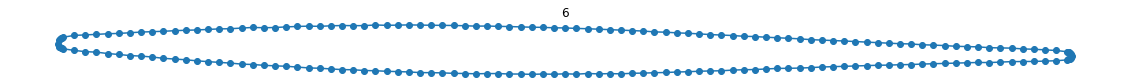

gen=  7
best7=  [[ 2.72363675  0.28990293  1.23724151  0.36267257 -0.34834117  1.1942459
  -1.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction7=  [0.7632565934676663, 221429992.9149042, 0.0005763353522203737]


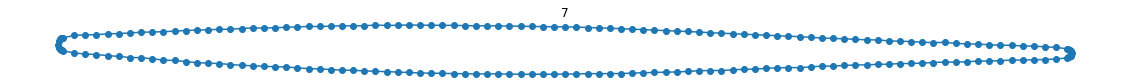

gen=  8
best8=  [[ 2.72363675  1.77757537  1.23724151  0.50544098 -0.190117    0.11601125
   1.62777787 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction8=  [0.7630381048004584, 217609992.61963856, 0.0005618428411468082]


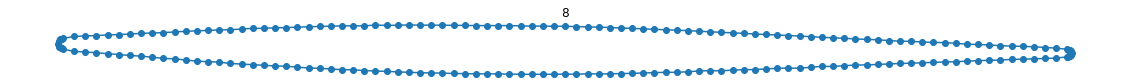

gen=  9
best9=  [[ 2.72363675  2.92839241 -0.14222896  0.3812027  -0.53960919 -0.10667043
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction9=  [0.7633899855820796, 220869992.42329556, 0.0005534353009616329]


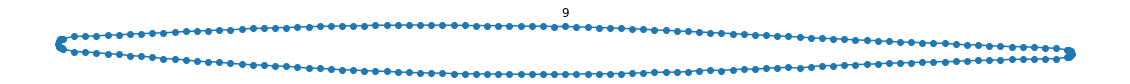

gen=  10
best10=  [[-1.72363675  1.77757537  1.23724151  0.36267257 -0.34834117  0.88398875
   0.29124162 -0.4693417   0.11677874 -1.57186425]] 
 best_prediction10=  [0.7630945539611591, 226949992.0820139, 0.0005421845936003297]


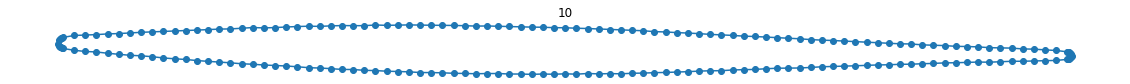

gen=  11
best11=  [[ 2.72363675  0.71009707 -0.09887451  0.79427218 -0.34834117 -0.1942459
  -0.62777787 -0.34610724 -0.59492928 -0.48538208]] 
 best_prediction11=  [0.7630430443914801, 221079992.89486867, 0.0005751168013174139]


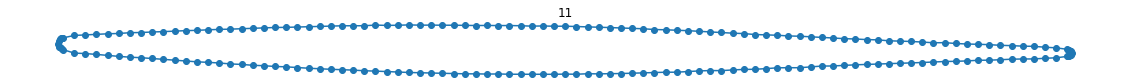

gen=  12
best12=  [[-0.27709666  2.92839241  1.23724151  1.31855726 -0.34834117 -0.1942459
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction12=  [0.7633561454708757, 219049992.3191107, 0.0005583644297529959]


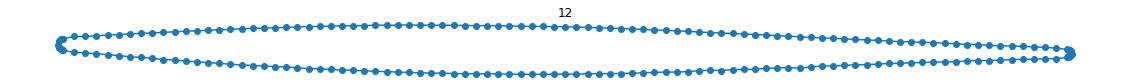

gen=  13
best13=  [[-0.27709666  2.92839241  1.23724151  1.31855726 -0.34834117 -0.1942459
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction13=  [0.7633561454708757, 219049992.3191107, 0.0005583644297529959]


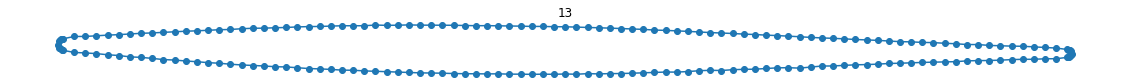

gen=  14
best14=  [[-0.27709666  2.92839241  1.23724151  1.31855726 -0.34834117 -0.1942459
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction14=  [0.7633561454708757, 219049992.3191107, 0.0005583644297529959]


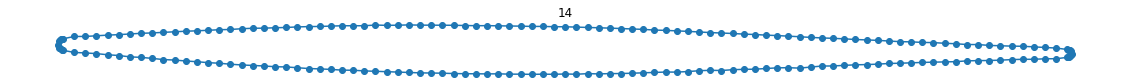

gen=  15
best15=  [[-0.27709666  2.92839241  1.23724151  1.31855726 -0.34834117 -0.1942459
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction15=  [0.7633561454708757, 219049992.3191107, 0.0005583644297529959]


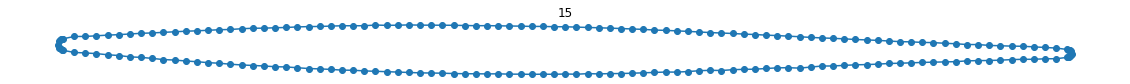

gen=  16
best16=  [[-0.27709666  2.92839241  1.23724151  1.31855726 -0.34834117 -0.1942459
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction16=  [0.7633561454708757, 219049992.3191107, 0.0005583644297529959]


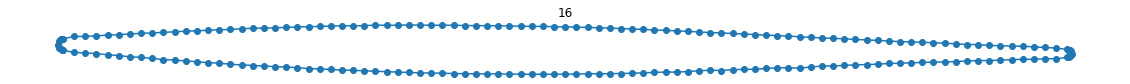

gen=  17
best17=  [[-0.27709666  2.92839241  1.23724151  1.31855726 -0.34834117 -0.1942459
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction17=  [0.7633561454708757, 219049992.3191107, 0.0005583644297529959]


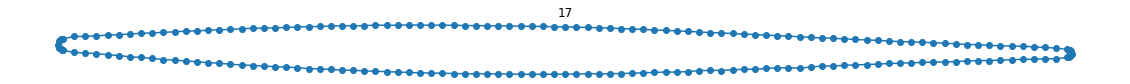

gen=  18
best18=  [[ 2.72363675  2.92839241 -0.14222896  0.50544098 -0.190117    0.88398875
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction18=  [0.7627741449061686, 216809992.49725106, 0.0005578020325321958]


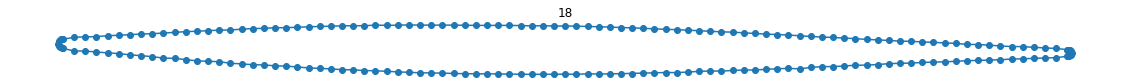

gen=  19
best19=  [[ 2.72363675  2.92839241  1.23724151  1.31855726 -0.190117    0.11601125
   2.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction19=  [0.763280437015663, 221449992.07353747, 0.0005461763107822894]


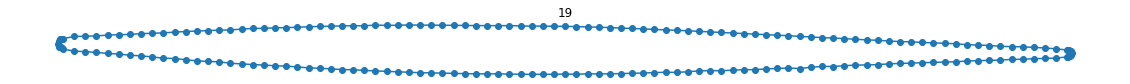

gen=  20
best20=  [[ 2.72363675  2.92839241  1.23724151  1.31855726 -0.190117    0.11601125
   2.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction20=  [0.763280437015663, 221449992.07353747, 0.0005461763107822894]


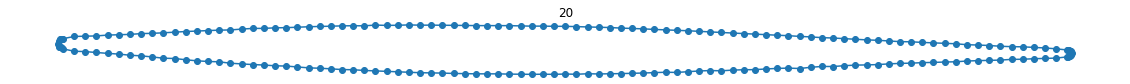

gen=  21
best21=  [[ 2.72363675  2.92839241  1.23724151  1.31855726 -0.190117    0.11601125
   2.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction21=  [0.763280437015663, 221449992.07353747, 0.0005461763107822894]


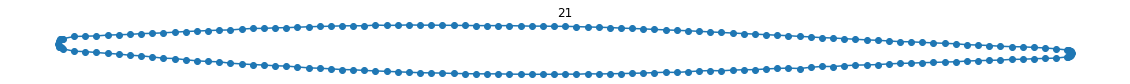

gen=  22
best22=  [[ 2.72363675  0.15065515 -0.09887451  0.79427218 -0.190117    0.11601125
  -0.62777787 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction22=  [0.7629809745096022, 217259992.676195, 0.0005632701710771737]


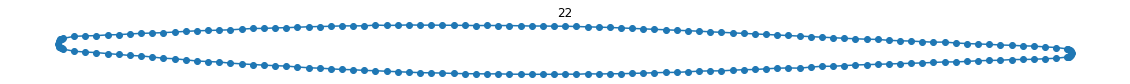

gen=  23
best23=  [[ 2.72363675  0.28990293 -0.23724151  0.63732743 -0.34834117  1.1942459
   0.29124162 -0.34610724  1.59492928  1.48538208]] 
 best_prediction23=  [0.763168005024872, 218229992.50194615, 0.0005632394804315329]


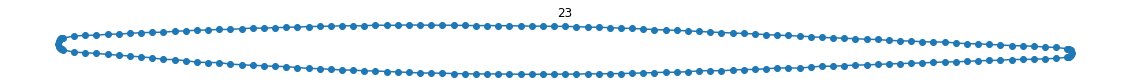

gen=  24
best24=  [[ 2.72363675  0.71009707 -0.09887451  0.50544098 -0.34834117 -0.1942459
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction24=  [0.7631488551264107, 218149992.49736664, 0.0005529912110925738]


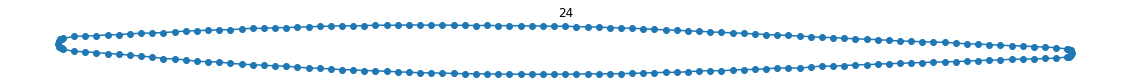

gen=  25
best25=  [[ 2.72363675  0.65004718 -0.09887451  0.79427218 -0.34834117  0.11601125
   1.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction25=  [0.7632789246352241, 217819992.47847596, 0.0005619056804128386]


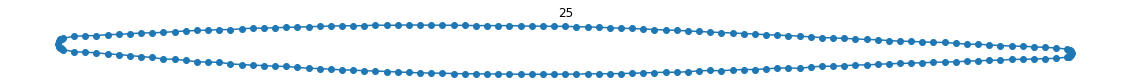

gen=  26
best26=  [[ 2.72363675  0.84934485 -0.09887451  0.20572782 -0.190117    0.88398875
   2.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction26=  [0.763284764947014, 218869992.46199062, 0.0005595568708967557]


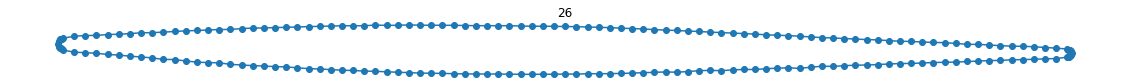

gen=  27
best27=  [[ 2.72363675  0.84934485 -0.09887451  0.20572782 -0.190117    0.88398875
   2.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction27=  [0.763284764947014, 218869992.46199062, 0.0005595568708967557]


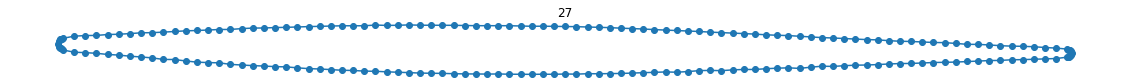

gen=  28
best28=  [[ 2.72363675  0.84934485 -0.09887451  0.20572782 -0.190117    0.88398875
   2.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction28=  [0.763284764947014, 218869992.46199062, 0.0005595568708967557]


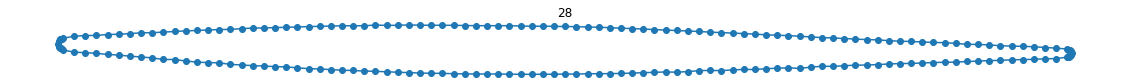

gen=  29
best29=  [[ 2.72363675  0.34995282 -0.23724151  0.49455902 -0.34834117 -0.1942459
  -0.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction29=  [0.7631488551264107, 218149992.49736664, 0.0005529912110925738]


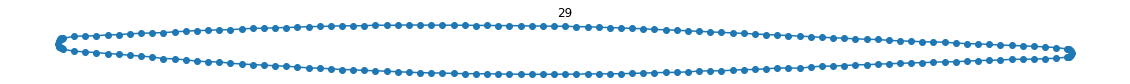

gen=  30
best30=  [[ 2.72363675  0.84934485 -0.09887451  0.50544098 -0.34834117  1.1942459
   1.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction30=  [0.7631683036681055, 216429992.39890623, 0.0005651794793717209]


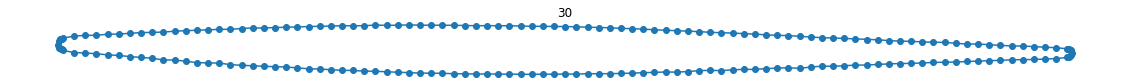

gen=  31
best31=  [[ 2.72363675  0.84934485 -0.09887451  0.50544098 -0.34834117  0.11601125
   0.29124162 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction31=  [0.7634544454083363, 219479992.3437258, 0.0005568994604212926]


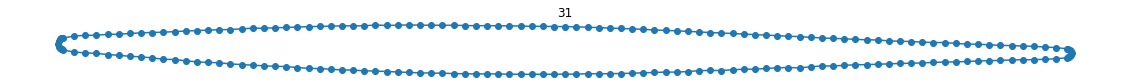

gen=  32
best32=  [[ 2.72363675  0.84934485 -0.09887451  0.50544098 -0.34834117  0.11601125
   0.29124162 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction32=  [0.7634544454083363, 219479992.3437258, 0.0005568994604212926]


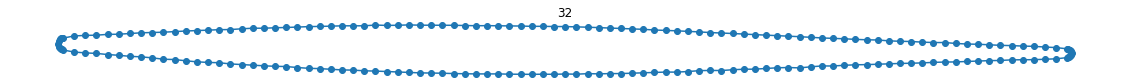

gen=  33
best33=  [[ 2.72363675  0.84934485 -0.09887451  0.50544098 -0.34834117  0.11601125
   0.29124162 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction33=  [0.7634544454083363, 219479992.3437258, 0.0005568994604212926]


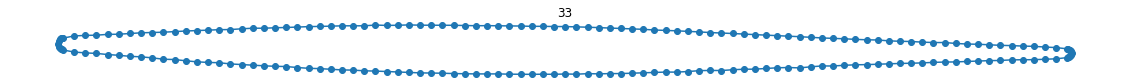

gen=  34
best34=  [[ 2.72363675  0.84934485 -0.09887451  0.50544098 -0.34834117  0.11601125
   0.29124162 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction34=  [0.7634544454083363, 219479992.3437258, 0.0005568994604212926]


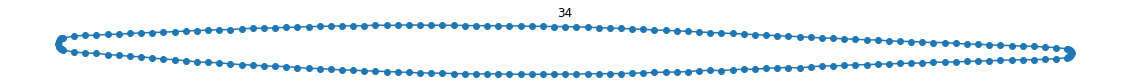

gen=  35
best35=  [[ 2.72363675  0.84934485 -0.09887451  0.50544098 -0.34834117  0.11601125
   0.29124162 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction35=  [0.7634544454083363, 219479992.3437258, 0.0005568994604212926]


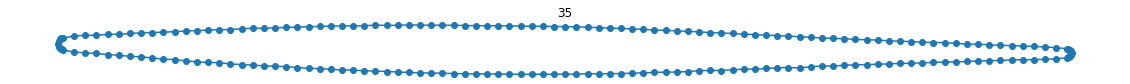

gen=  36
best36=  [[ 2.72363675  0.84934485 -0.09887451  0.63732743 -0.34834117 -0.1942459
   1.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction36=  [0.7632659855578049, 218699992.4522591, 0.0005517638812967928]


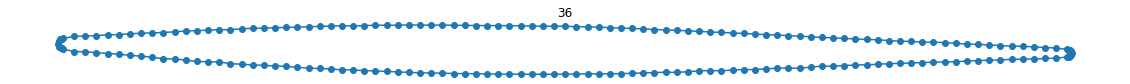

gen=  37
best37=  [[ 2.72363675  0.65004718  1.23724151  0.63732743 -0.34834117  0.88398875
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction37=  [0.7633417131772893, 217559992.38700044, 0.0005621978700093065]


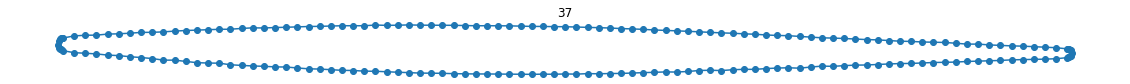

gen=  38
best38=  [[ 2.72363675  0.84934485 -0.09887451  0.49455902 -0.34834117  0.11601125
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction38=  [0.7628920546846103, 217119992.59158882, 0.000555341020679549]


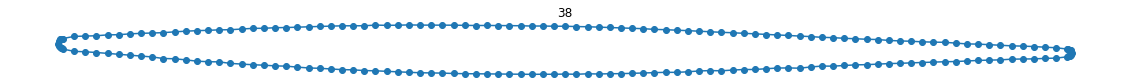

gen=  39
best39=  [[ 2.72363675  0.84934485 -0.09887451  0.63732743 -0.34834117  0.11601125
   0.29124162 -0.34610724  1.59492928  1.48538208]] 
 best_prediction39=  [0.7628654546755393, 214829992.69027498, 0.0005631364616727966]


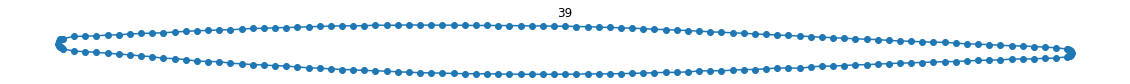

gen=  40
best40=  [[ 2.72363675  0.84934485 -0.23724151  0.36267257 -0.34834117  0.11601125
  -0.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction40=  [0.7629713053360359, 215759992.66692033, 0.0005582644119460869]


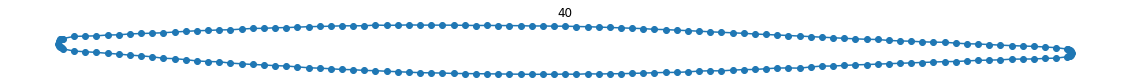

gen=  41
best41=  [[ 2.72363675  0.84934485 -0.23724151  0.36267257 -0.34834117  0.11601125
  -0.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction41=  [0.7629713053360359, 215759992.66692033, 0.0005582644119460869]


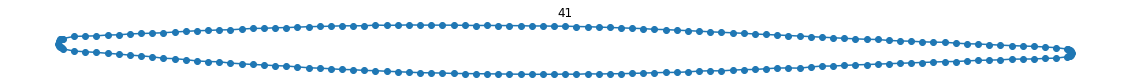

gen=  42
best42=  [[ 2.72363675  0.15065515  1.09887451  0.49455902 -0.34834117  0.88398875
   0.29124162 -0.34610724  1.59492928  1.48538208]] 
 best_prediction42=  [0.763207273416025, 217329992.52701816, 0.0005629892605507577]


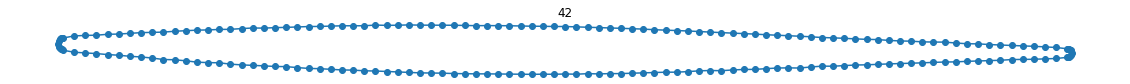

gen=  43
best43=  [[ 2.72363675  0.15065515  1.09887451  0.49455902 -0.34834117  0.11601125
  -0.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction43=  [0.7631780055806359, 218129992.49622172, 0.000562539479960487]


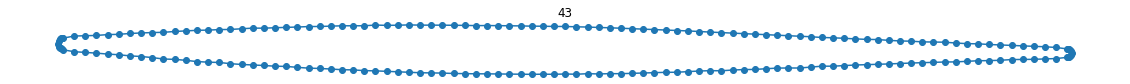

gen=  44
best44=  [[ 2.72363675  0.15065515 -0.09887451  0.49455902 -0.34834117  0.88398875
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction44=  [0.7632172739717888, 217229992.52129373, 0.0005622892600797117]


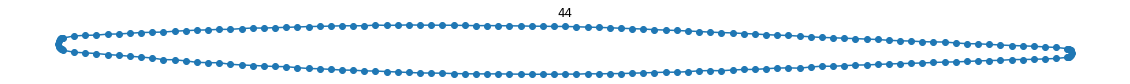

gen=  45
best45=  [[ 2.72363675  0.84934485  1.23724151  0.6187973  -0.190117    0.11601125
   2.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction45=  [0.7627434541236083, 215149992.7085932, 0.0005617863722510547]


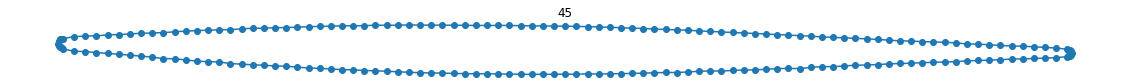

gen=  46
best46=  [[ 2.72363675  0.84934485 -0.09887451  1.31855726 -0.190117    0.11601125
   2.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction46=  [0.7632546554806943, 218859992.38482624, 0.0005626714811876048]


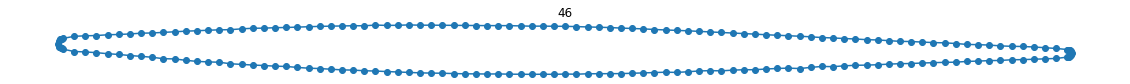

gen=  47
best47=  [[ 2.72363675  0.84934485 -0.09887451  0.63732743 -0.34834117 -0.1942459
   0.29124162 -0.34610724  1.59492928  1.48538208]] 
 best_prediction47=  [0.7627553647184482, 215619992.6589061, 0.0005602904121785279]


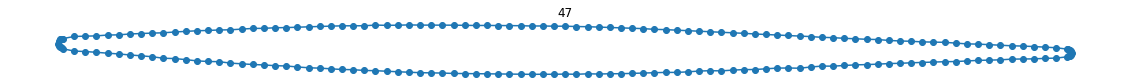

gen=  48
best48=  [[ 2.72363675  0.15065515 -0.09887451  0.79427218 -0.34834117  0.88398875
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction48=  [0.7632172739717888, 217229992.52129373, 0.0005622892600797117]


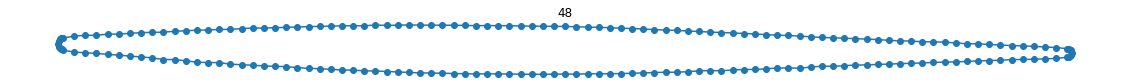

gen=  49
best49=  [[ 2.72363675  0.15065515 -0.09887451  0.79427218 -0.34834117  0.88398875
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction49=  [0.7632172739717888, 217229992.52129373, 0.0005622892600797117]


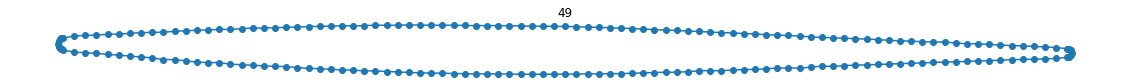

gen=  50
best50=  [[ 2.72363675  0.15065515 -0.09887451  0.36267257 -0.190117    0.11601125
   2.172526   -0.34610724  1.59492928 -0.48538208]] 
 best_prediction50=  [0.763337974547292, 218319992.50709817, 0.0005601834408114424]


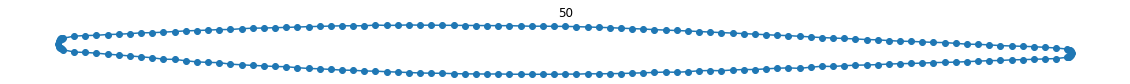

gen=  51
best51=  [[ 2.72363675  0.84934485  1.09887451  0.63732743 -0.34834117 -0.1942459
  -0.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction51=  [0.763261325445745, 218539992.5962839, 0.0005590875105741125]


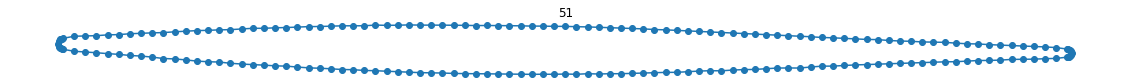

gen=  52
best52=  [[ 2.72363675  0.84934485  1.09887451  0.63732743 -0.34834117 -0.1942459
  -0.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction52=  [0.763261325445745, 218539992.5962839, 0.0005590875105741125]


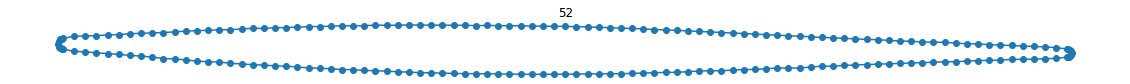

gen=  53
best53=  [[ 2.72363675  0.84934485  1.09887451  0.63732743 -0.34834117  0.11601125
   1.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction53=  [0.76329418578356, 218979992.46828753, 0.0005593899104287251]


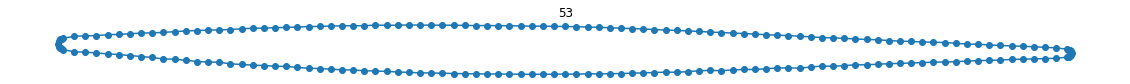

gen=  54
best54=  [[ 2.72363675  0.84934485  1.09887451  0.63732743 -0.34834117  0.11601125
   1.62777787 -0.34610724  1.59492928  1.48538208]] 
 best_prediction54=  [0.76329418578356, 218979992.46828753, 0.0005593899104287251]


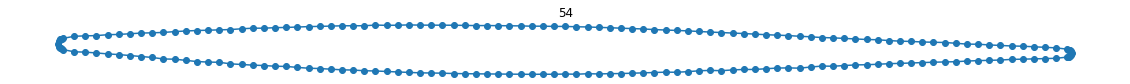

gen=  55
best55=  [[ 2.72363675  0.84934485 -0.09887451  0.36267257 -0.34834117 -0.1942459
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction55=  [0.7629288548772752, 217649992.54533637, 0.0005528912110252815]


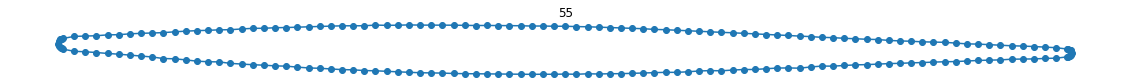

gen=  56
best56=  [[ 2.72363675  0.84934485 -0.09887451  0.49455902 -0.34834117  0.11601125
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction56=  [0.7628920546846103, 217119992.59158882, 0.000555341020679549]


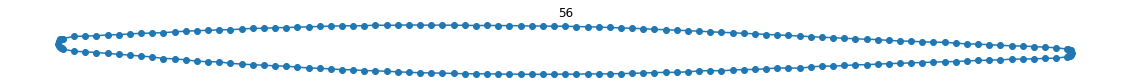

gen=  57
best57=  [[ 2.72363675  0.84934485 -0.09887451  0.36267257 -0.34834117 -0.1942459
  -1.172526   -0.34610724  1.59492928  1.48538208]] 
 best_prediction57=  [0.7631488551264107, 218149992.49736664, 0.0005529912110925738]


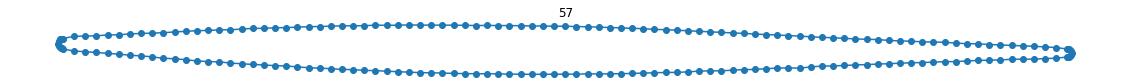

gen=  58
best58=  [[ 2.72363675  0.84934485 -0.09887451  0.49455902 -0.34834117  0.88398875
   0.70875838 -0.34610724  1.59492928  1.48538208]] 
 best_prediction58=  [0.7631741751218368, 217129992.6687532, 0.0005651199803276875]


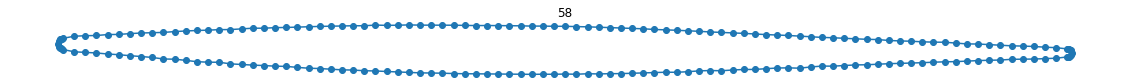

gen=  59
best59=  [[ 2.72363675  0.84934485 -0.09887451  0.49455902 -0.34834117  0.11601125
   0.29124162 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction59=  [0.7634544454083363, 219479992.3437258, 0.0005568994604212926]


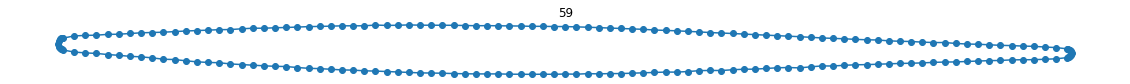

best59=  [[ 2.72363675  0.84934485 -0.09887451  0.49455902 -0.34834117  0.11601125
   0.29124162 -0.34610724  1.59492928 -0.48538208]] 
 best_prediction59=  [0.7634544454083363, 219479992.3437258, 0.0005568994604212926]


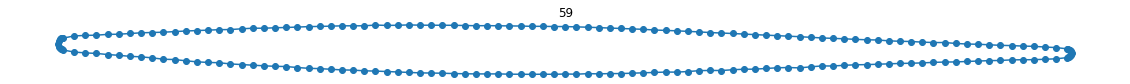

In [ ]:

n_generations=60
n_pop=120       
r_cross=0.8
r_mut=0.7

efficiency_gen=[]
stress_gen=[]
deformation_gen=[]
## Initial population ##
feature_domain=encoder(vnum)
pop= combination(n_pop,feature_domain,codings_size)
for n in range(len(pop)):
  pp=np.array(pop[n]).reshape(1,-1)
  initialpop=decoder(pp)
  initialpop=tf.reshape(initialpop,[200])
  m=predictions(decode(pp))
  plot_image(initialpop,n=m)
## keep track of the best solution ##
p=np.array(pop[0]).reshape(1,-1)
best= p
best_efficiency=predictions(decode(best))[0,0]
best_stress= predictions(decode(best))[0,1]
best_deformation= predictions(decode(best))[0,2]
## enumerate generations
for gen in range(n_generations):
  print("gen= ",gen)
  for i in range(n_pop):
    p=np.array(pop[i]).reshape(1,-1)
    decoded=decode(p)
    prediction= predictions(decoded)
    efficiency=prediction[0,0]
    stress=prediction[0,1]
    deformation=prediction[0,2]
## check for new best solution 
    if efficiency >= best_efficiency and stress <= best_stress or deformation <= best_deformation:
      best= p
      best_efficiency= efficiency
      best_stress= stress
      best_deformation= deformation
## select parents 
  parents=list()
  for n in range(n_pop):
    parents.append(selection(pop,0.77,k=5))
## create the next generation 
  children = list()
  for i in range(0, n_pop, 2):
    p1, p2 = parents[i], parents[i+1]
    c1, c2 = np.copy(p1), np.copy(p2)
    p1, p2=np.array(p1), np.array(p2)
    p1, p2=p1.tolist(), p2.tolist()
## Crossover and Mutation
    # pt=0
    if rand() < r_cross:
      pt = randint(1, len(p1)-2)
      c1 = p1[:pt] + p2[pt:]
      c2 = p2[:pt] + p1[pt:]
    for c in [c1,c2]:
      c=np.array(c)
      for i in range(len(c)):
        if rand() < r_mut:
          c[i] = 1 - c[i]
      c=c.tolist()
      children.append(c)
## Replace population
  pop = children
  print(f"best{gen}= ",best,"\n" , f"best_prediction{gen}= ",[best_efficiency,best_stress,best_deformation])
  efficiency_gen.append(best_efficiency)
  stress_gen.append(best_stress)
  deformation_gen.append(best_deformation)
  y=decoder(best)
  y=tf.reshape(y,[200])
  n=gen
  plot_image(y,n)

print(f"best{gen}= ",best,"\n" ,f"best_prediction{gen}= ",[best_efficiency,best_stress,best_deformation])
plot_image(y,n)

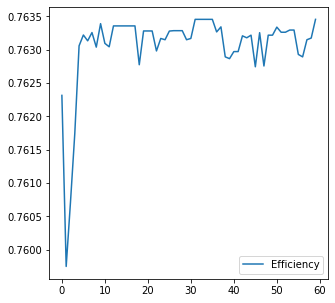

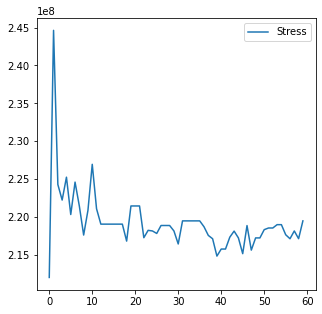

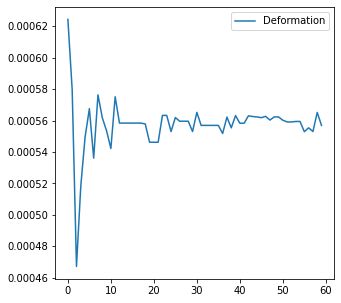

In [ ]:
x_axis=np.arange(n_generations)
plt.figure(figsize=(5,5))
plt.plot(x_axis,efficiency_gen, label="Efficiency")
plt.legend()

plt.figure(figsize=(5,5))
plt.plot(x_axis,stress_gen, label="Stress")
plt.legend()

plt.figure(figsize=(5,5))
plt.plot(x_axis,deformation_gen, label="Deformation")
plt.legend()